##SFR package example
Demonstrates functionality of Flopy SFR module using the example documented by Prudic and others (2004):  

####Problem description:
Grid dimensions: 1 Layer, 15 Rows, 10 Columns  
Stress periods: 1 steady  
Flow package: LPF  
Stress packages: SFR, GHB, EVT, RCH  
Solver: SIP  
![alt text](https://github.com/modflowpy/flopy/tree/develop/examples/images/Prudic2004_fig6.tiff "Logo Title Text 1")

Prudic, D.E., Konikow, L.F., and Banta, E.R., 2004, A new streamflow-routing
(SFR1) package to simulate stream-aquifer interaction with MODFLOW-2000:
U.S. Geological Survey Open-File Report 2004-1042, 95 p.
available at <http://pubs.er.usgs.gov/publication/ofr20041042>

In [35]:
import sys
sys.path.insert(0, '../..')
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

% matplotlib inline

In [2]:
path = os.path.join('..', 'data', 'mf2005_test')

###Load example dataset, skipping the SFR package

In [3]:
m = flopy.modflow.Modflow.load('test1ss', model_ws=path, load_only=['ghb', 'evt', 'rch', 'dis', 'bas6', 'oc', 'sip'])
m.get_package_list()

['DIS', 'SIP', 'OC', 'GHB', 'EVT', 'RCH', 'BAS6']

###Read pre-prepared reach and segment data into numpy recarrays using numpy.genfromtxt()
Reach data (Item 2 in the SFR input instructions), are input and stored in a numpy record array  
http://docs.scipy.org/doc/numpy/reference/generated/numpy.recarray.html  
This allows for reach data to be indexed by their variable names, as described in the SFR input instructions.

For more information on Item 2, see the Online Guide to MODFLOW:  
<http://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?sfr.htm>

In [4]:
reach_data = np.genfromtxt('data/test1ss_reach_data.csv', delimiter=',', names=True)
reach_data

array([(0.0, 0.0, 0.0, 1.0, 1.0, 4500.0),
       (0.0, 1.0, 1.0, 1.0, 2.0, 7000.0),
       (0.0, 2.0, 2.0, 1.0, 3.0, 6000.0),
       (0.0, 2.0, 3.0, 1.0, 4.0, 5550.0),
       (0.0, 3.0, 4.0, 2.0, 1.0, 6500.0),
       (0.0, 4.0, 5.0, 2.0, 2.0, 5000.0),
       (0.0, 5.0, 5.0, 2.0, 3.0, 5000.0),
       (0.0, 6.0, 5.0, 2.0, 4.0, 5000.0),
       (0.0, 7.0, 5.0, 2.0, 5.0, 5000.0),
       (0.0, 2.0, 4.0, 3.0, 1.0, 5000.0),
       (0.0, 2.0, 5.0, 3.0, 2.0, 5000.0),
       (0.0, 2.0, 6.0, 3.0, 3.0, 4500.0),
       (0.0, 3.0, 7.0, 3.0, 4.0, 6000.0),
       (0.0, 4.0, 7.0, 3.0, 5.0, 5000.0),
       (0.0, 5.0, 7.0, 3.0, 6.0, 2000.0),
       (0.0, 4.0, 9.0, 4.0, 1.0, 2500.0),
       (0.0, 4.0, 8.0, 4.0, 2.0, 5000.0),
       (0.0, 5.0, 7.0, 4.0, 3.0, 3500.0),
       (0.0, 5.0, 7.0, 5.0, 1.0, 4000.0),
       (0.0, 6.0, 6.0, 5.0, 2.0, 5000.0),
       (0.0, 7.0, 6.0, 5.0, 3.0, 3500.0),
       (0.0, 7.0, 5.0, 5.0, 4.0, 2500.0),
       (0.0, 8.0, 5.0, 6.0, 1.0, 5000.0),
       (0.0, 9.0, 6.0, 6.0, 2.0, 5

###Segment Data structure
Segment data are input and stored in a dictionary of record arrays, which 

In [22]:
ss_segment_data = np.genfromtxt('data/test1ss_segment_data.csv', delimiter=',', names=True)
segment_data = {0: ss_segment_data}
segment_data[0][0:1]['width1']

array([ 0.])

### define dataset 6e (channel flow data) for segment 1
dataset 6e is stored in a nested dictionary keyed by stress period and segment,  
with a list of the following lists defined for each segment with icalc == 4  
FLOWTAB(1) FLOWTAB(2) ... FLOWTAB(NSTRPTS)  
DPTHTAB(1) DPTHTAB(2) ... DPTHTAB(NSTRPTS)  
WDTHTAB(1) WDTHTAB(2) ... WDTHTAB(NSTRPTS)  

In [25]:
channel_flow_data = {0: {1: [[0.5, 1.0, 2.0, 4.0, 7.0, 10.0, 20.0, 30.0, 50.0, 75.0, 100.0],
                             [0.25, 0.4, 0.55, 0.7, 0.8, 0.9, 1.1, 1.25, 1.4, 1.7, 2.6],
                             [3.0, 3.5, 4.2, 5.3, 7.0, 8.5, 12.0, 14.0, 17.0, 20.0, 22.0]]}}

### define dataset 6d (channel geometry data) for segments 7 and 8
dataset 6d is stored in a nested dictionary keyed by stress period and segment,  
with a list of the following lists defined for each segment with icalc == 4  
FLOWTAB(1) FLOWTAB(2) ... FLOWTAB(NSTRPTS)  
DPTHTAB(1) DPTHTAB(2) ... DPTHTAB(NSTRPTS)  
WDTHTAB(1) WDTHTAB(2) ... WDTHTAB(NSTRPTS)  

In [26]:
channel_geometry_data = {0: {7: [[0.0, 10.0, 80.0, 100.0, 150.0, 170.0, 240.0, 250.0],
                                 [20.0, 13.0, 10.0, 2.0, 0.0, 10.0, 13.0, 20.0]],
                             8: [[0.0, 10.0, 80.0, 100.0, 150.0, 170.0, 240.0, 250.0],
                                 [25.0, 17.0, 13.0, 4.0, 0.0, 10.0, 16.0, 20.0]]}}

###Define SFR package variables  

In [6]:
nstrm = len(reach_data)
nss = len(segment_data[0])
nsfrpar = 0
nparseg = 0
const = 1.486
dleak = 0.0001
istcb1 = -1
istcb2 = 81
dataset_5 = {0: [nss, 0, 0]}

###Instantiate SFR package  
Input arguments generally follow the variable names defined in the Online Guide to MODFLOW

In [27]:
sfr = flopy.modflow.ModflowSfr2(m, nstrm=nstrm, nss=nss, const=1.486, istcb1=-1, istcb2=81, 
                                reach_data=reach_data,
                                segment_data=segment_data,
                                channel_geometry_data=channel_geometry_data,
                                channel_flow_data=channel_flow_data,
                                dataset_5=dataset_5)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfsfr2.ModflowSfr2'> <class 'flopy.modflow.mfsfr2.ModflowSfr2'>
replacing existing Package...


In [28]:
sfr.reach_data[0:1]

rec.array([ (1, 0, 0, 0, 1, 1, 4500.0, -10000000000.0, -10000000000.0, -10000000000.0, -10000000000.0, -10000000000, -10000000000.0, -10000000000.0, -10000000000.0, 1, 2)], 
          dtype=[('node', '<i8'), ('k', '<i8'), ('i', '<i8'), ('j', '<i8'), ('iseg', '<i8'), ('ireach', '<i8'), ('rchlen', '<f4'), ('strtop', '<f4'), ('slope', '<f4'), ('strthick', '<f4'), ('strhc1', '<f4'), ('thts', '<i8'), ('thti', '<f4'), ('eps', '<f4'), ('uhc', '<f4'), ('reachID', '<i8'), ('outreach', '<i8')])

### Plot the SFR segments
any column in the reach_data array can be plotted using the ```key``` argument

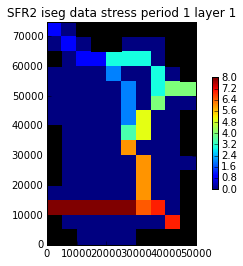

In [38]:
sfr.plot(key='iseg')

### Check the SFR dataset for errors

In [30]:
chk = sfr.check()

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking for model cells with multiple non-zero SFR conductances...
3 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
node	k	i	j	iseg	ireach	rchlen
76	0	7	5	2	5	5000.000000
58	0	5	7	3	6	2000.000000
58	0	5	7	4	3	3500.000000
58	0	5	7	5	1	4000.000000
76	0	7	5	5	4	2500.000000
127	0	12	6	6	5	2000.000000
127	0	12	6	7	3	5000.000000

Checking segment_data for downstream rises in streambed elevation...
passed.

Checking reach_data for downstream rises in streambed elevation...
Reach strtop not specified for nstrm=36, reachinput=False and isfropt=0
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
Reach strtop, strthick not specified for nstrm=36, reachinpu

In [31]:
chk.failed

['overlapping conductance']

In [32]:
chk.passed

['continuity in segment and reach numbering',
 'segment numbering order',
 'circular routing',
 'segment elevations',
 'reach elevations',
 'reach elevations vs. grid elevations',
 'segment elevations vs. model grid',
 'minimum slope',
 'maximum slope']

array([  0.,  12.,   6.,  10.,   0.,  12.,   0.,   0.], dtype=float32)